<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 14.3 MB/s 
     |████████████████████████████████| 1.6 MB 56.0 MB/s 


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

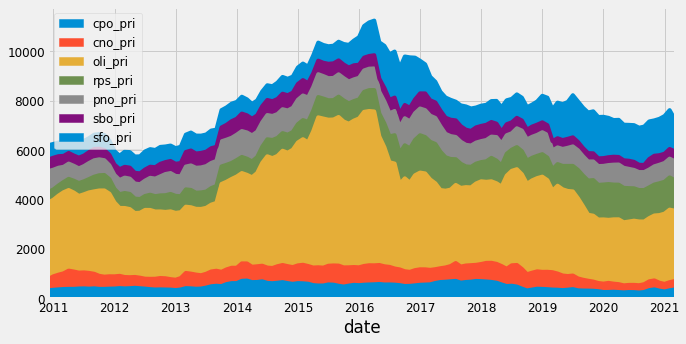

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [67]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [71]:
len(X_test)

22

In [10]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [11]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [12]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [13]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [14]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [15]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [16]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [34]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1, 'linear'))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=300, batch_size = 128, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/300
1/1 [==============================] - 1s 604ms/step - loss: 0.1700 - mse: 0.1700 - val_loss: 0.1353 - val_mse: 0.1353
Epoch 2/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 3/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 4/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 5/300
1/1 [==============================] - 0s 30ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 6/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 7/300
1/1 [==============================] - 0s 34ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 8/300
1/1 [==============================] - 0s 28ms/step - loss: 0.0430 - mse: 0.0

[0.014398680068552494, 0.014398680068552494]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


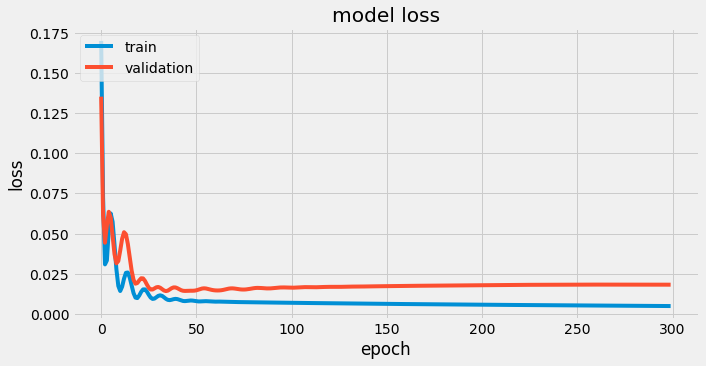

In [47]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 0.0144 - mse: 0.0144


####Baseline MSE = 0.0144

In [37]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             960       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
____________________________________________________

###Predict the Test without Hyperparameter Tuning

In [38]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 56ms/step


array([[ 0.11801072],
       [ 0.06105023],
       [ 0.1032806 ],
       [ 0.09626149],
       [ 0.04069581],
       [ 0.06271359],
       [ 0.0467217 ],
       [ 0.02992017],
       [-0.03683222],
       [-0.03615967],
       [-0.05898342],
       [-0.08746617],
       [-0.07961488],
       [-0.06633773],
       [-0.03607479],
       [-0.100775  ],
       [-0.11426748],
       [-0.00707853],
       [ 0.19366716],
       [ 0.10846869],
       [ 0.01988528],
       [ 0.0588681 ]], dtype=float32)

In [39]:
y_pred.reshape(1,-1)

array([[ 0.11801072,  0.06105023,  0.1032806 ,  0.09626149,  0.04069581,
         0.06271359,  0.0467217 ,  0.02992017, -0.03683222, -0.03615967,
        -0.05898342, -0.08746617, -0.07961488, -0.06633773, -0.03607479,
        -0.100775  , -0.11426748, -0.00707853,  0.19366716,  0.10846869,
         0.01988528,  0.0588681 ]], dtype=float32)

###Invert Transformed Data

In [40]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[366.20428 343.4201  360.31226 357.5046  335.27832 344.08542 337.6887
  330.96808 304.26712 304.53613 295.40662 284.01352 287.15405 292.4649
  304.57007 278.69    273.29303 316.16858 396.4669  362.38745 326.9541
  342.54724]]


###Plot History, Actual and Predicted Value

In [41]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [42]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [43]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([366.20428, 343.4201 , 360.31226, 357.5046 , 335.27832, 344.08542,
       337.6887 , 330.96808, 304.26712, 304.53613, 295.40662, 284.01352,
       287.15405, 292.4649 , 304.57007, 278.69   , 273.29303, 316.16858,
       396.4669 , 362.38745, 326.9541 , 342.54724], dtype=float32)

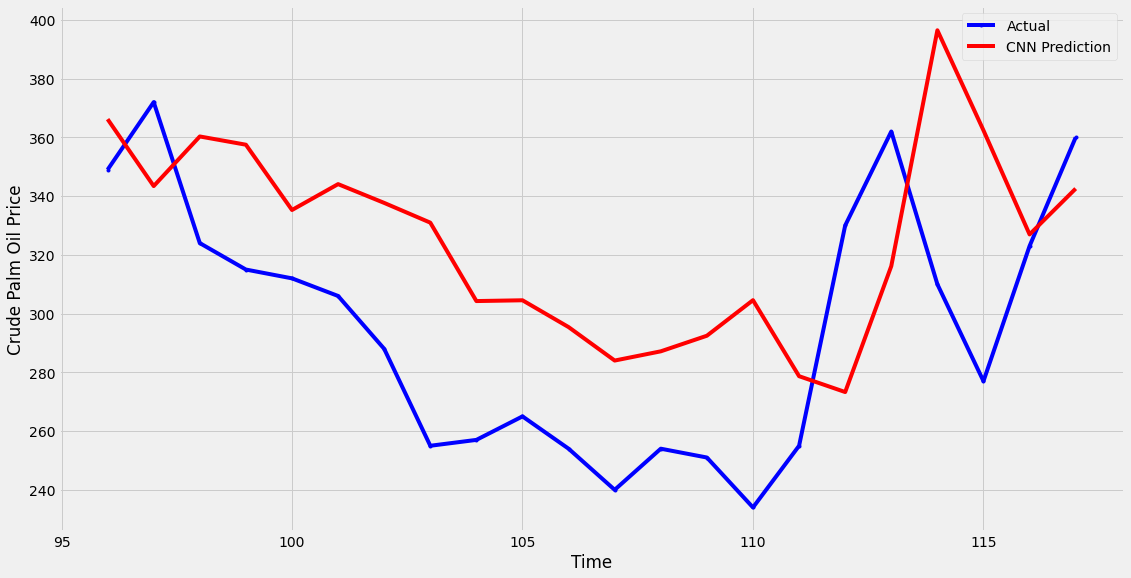

In [93]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluate CNN Model Accuracy

In [94]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 43.11470725319602
MDA value of the CNN Model is: 0.5238095238095238
MAPE value of the CNN Model is: 15.26695556459704
RMSE value of the CNN Model is: 47.997798772720316
MSE value of the CNN Model is: 2303.7886870265515


####CNN Actual VS Prediction Plot Zoomed-In

###Tuning CNN with Keras Tuner

In [96]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(1))

        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        #model.add(
            #layers.Dense(
                #hp.Float(
                    #'batch_size',
                    #'type": "range', ###########
                     #min_value= 10, 
                     #max_value=60,
                     #default=1,
                     #step=20)
                    #'value_type': "int" ###########
            #)
        #)
       #---------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [97]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [98]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [99]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 340ms/step - loss: 0.1334 - mae: 0.3459 - mse: 0.1334


####Random Search MSE = 0.1334

In [100]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 48,
 'dropout': 0.1,
 'learning_rate': 0.0038287047044982298}

###Build Bayesian Optimization

In [101]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [102]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 339ms/step - loss: 0.2829 - mae: 0.5208 - mse: 0.2829


###Bayesian Optimization Search MSE = 0.2829

###Evaluate Bayesian Optimization

In [103]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 64,
 'units_3': 64,
 'dropout': 0.0,
 'learning_rate': 0.01}

In [104]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 344ms/step - loss: 0.2829 - mae: 0.5208 - mse: 0.2829


###Build HYPERBAND optimization

In [53]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [54]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [55]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


789.8020212650299  secs


In [56]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
drop out is {best_hps.get('dropout')}
#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')

'''
print(best_hps.get('units'))
print(best_hps.get('layers'))
print(best_hps.get('window'))
print(best_hps.get('learning_rate'))
'''


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 48 
drop out is 0.45
#learning rate is 0.007588827342097074                                        

and the optimal learning rate for the optimizer
is 0.007588827342097074.

[]
1/1 [==============================] - 0s 319ms/step - loss: 0.0114 - mae: 0.0948 - mse: 0.0114
loss:0.01140345074236393 mae: 0.09478043019771576 mse: 0.01140345074236393


"\nprint(best_hps.get('units'))\nprint(best_hps.get('layers'))\nprint(best_hps.get('window'))\nprint(best_hps.get('learning_rate'))\n"

In [92]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 96, 'units_3': 48, 'dropout': 0.45, 'learning_rate': 0.007588827342097074, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0239'}


###Apply the trained parameters to the CNN

In [137]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())
TUcnn_model.add(tf.keras.layers.Dense(48, activation='tanh'))
TUcnn_model.add(layers.Dropout(0.45))

TUcnn_model.add(tf.keras.layers.Dense(1))
# compile model using adam
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adam(learning_rate=0.003021691068008031), metrics= ['mae', 'mse'])
TUcnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),

history = TUcnn_model.fit(X_train, y_train, epochs=160, batch_size = 120, validation_split=0.2) #epochs =200, bs = 128 , RMSE=46
#epochs =200, bs = 144 , RMSE=51.72
#epochs =200, bs = 144 , opt = rmsprop, RMSE=38.76/44.25
#epochs =100, bs = 144 , opt = rmsprop, RMSE=41.62
#epochs =200, bs = 160 , opt = rmsprop, RMSE=40
#epochs =300, bs = 160 , opt = SGD,     RMSE = 37.87 jag
#epochs =300, bs = 160 , opt = AdaMax,  RMSE = 42.13 smoo
#epochs =200, bs = 128 , opt = rmsprop,  RMSE = 36.24 smoo

#rmsprop

# model evaluation
TUcnn_model.evaluate(X_test, y_test)

Epoch 1/160
1/1 [==============================] - 1s 846ms/step - loss: 0.3150 - mse: 0.3150 - val_loss: 0.4253 - val_mse: 0.4253
Epoch 2/160
1/1 [==============================] - 0s 31ms/step - loss: 0.3891 - mse: 0.3891 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 3/160
1/1 [==============================] - 0s 35ms/step - loss: 0.0921 - mse: 0.0921 - val_loss: 0.0842 - val_mse: 0.0842
Epoch 4/160
1/1 [==============================] - 0s 31ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 5/160
1/1 [==============================] - 0s 31ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0673 - val_mse: 0.0673
Epoch 6/160
1/1 [==============================] - 0s 30ms/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 7/160
1/1 [==============================] - 0s 29ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0617 - val_mse: 0.0617
Epoch 8/160
1/1 [==============================] - 0s 32ms/step - loss: 0.0406 - mse: 0.0

[0.010226077400147915, 0.010226077400147915]

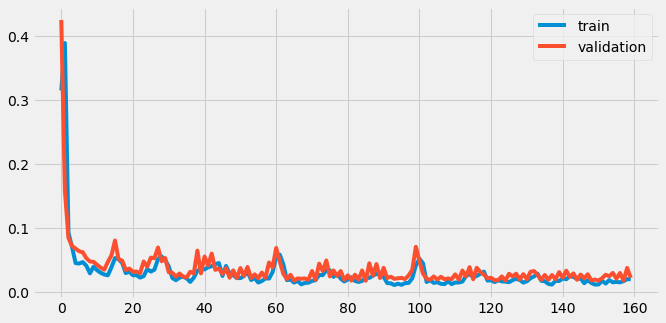

In [138]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [139]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 99ms/step


array([[ 0.03631685],
       [ 0.01028047],
       [ 0.03287637],
       [ 0.04287671],
       [ 0.00228472],
       [ 0.0009554 ],
       [ 0.00469817],
       [-0.00818815],
       [-0.04745047],
       [-0.07269085],
       [-0.07071958],
       [-0.07266927],
       [-0.08324015],
       [-0.07655969],
       [-0.07092023],
       [-0.09318746],
       [-0.10972482],
       [-0.02038732],
       [ 0.10480584],
       [ 0.08294968],
       [ 0.01587376],
       [ 0.01147996]], dtype=float32)

In [140]:
y_predTU.reshape(1,-1)

array([[ 0.03631685,  0.01028047,  0.03287637,  0.04287671,  0.00228472,
         0.0009554 ,  0.00469817, -0.00818815, -0.04745047, -0.07269085,
        -0.07071958, -0.07266927, -0.08324015, -0.07655969, -0.07092023,
        -0.09318746, -0.10972482, -0.02038732,  0.10480584,  0.08294968,
         0.01587376,  0.01147996]], dtype=float32)

###Invert Transformed Tuned Data

In [141]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[333.52673 323.11218 332.15054 336.1507  319.91388 319.38217 320.87927
  315.72473 300.0198  289.92368 290.71216 289.9323  285.70395 288.37613
  290.63193 281.72504 275.11008 310.84506 360.92233 352.17987 325.3495
  323.59198]]


In [142]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [143]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [144]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([333.52673, 323.11218, 332.15054, 336.1507 , 319.91388, 319.38217,
       320.87927, 315.72473, 300.0198 , 289.92368, 290.71216, 289.9323 ,
       285.70395, 288.37613, 290.63193, 281.72504, 275.11008, 310.84506,
       360.92233, 352.17987, 325.3495 , 323.59198], dtype=float32)

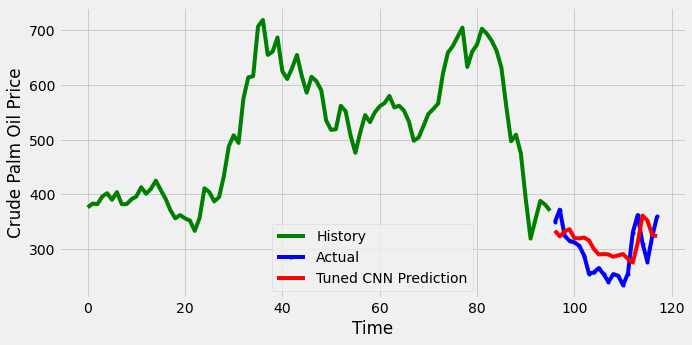

In [145]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time')
plt.legend()
plt.show();

In [148]:
TUMAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', TUMAE_cnn)

TUMDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', TUMDA_cnn)

TUMAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', TUMAPE_cnn)

TURMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', TURMSE_cnn)

TUMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', TUMSE_cnn)

MAE value of the CNN Model is: 35.7496337890625
MDA value of the CNN Model is: 0.2857142857142857
MAPE value of the CNN Model is: 12.617086287504387
RMSE value of the CNN Model is: 40.4496306423613
MSE value of the CNN Model is: 1636.172619103454


Tuned CNN Actual VS Predicted Zoomed-IN

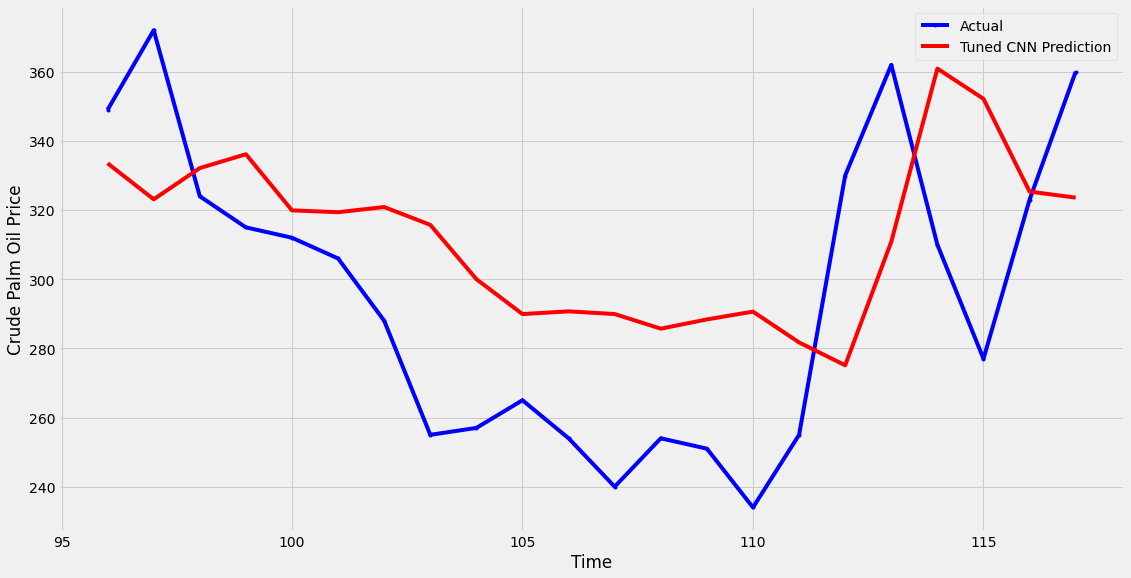

In [150]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

##Results

Baseline MSE         = 

Random search MSE    =

Hyperband search MSE = 

Tuned CNN MSE        =